In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.3):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


KTF.set_session(get_session())

Using TensorFlow backend.


In [3]:
!nvidia-smi

Tue Nov 21 13:28:57 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    70W / 149W |   3519MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import os
import re
import json

import unet
import dataset
import train_test_loader
import learning_experiment as lexperiment

import datetime

from shutil import copyfile

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
experiment16 = lexperiment.LearningExperiment('./experiments/2017-11-20 16:26:32.860734')
experiment14 = lexperiment.LearningExperiment('./experiments/2017-11-19 15:54:55.996135')
experiment13 = lexperiment.LearningExperiment('./experiments/2017-11-19 11:16:56.979773')
experiment17 = lexperiment.LearningExperiment('./experiments/2017-11-20 20:12:38.876558')

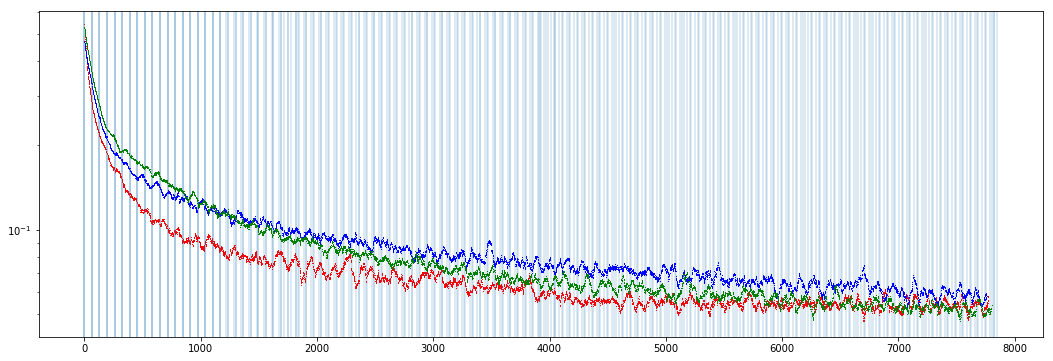

In [8]:
loss16 = experiment16.loss_history()
loss14 = experiment14.loss_history() # load_net(input_shape=(240,240,3))
loss13 = experiment13.loss_history() # load_net(input_shape=(240,240,8))

plt.figure(figsize=(18,6))
#plt.xlim((1000,5000))
#plt.ylim((3e-2, 0.2))
plt.yscale('log')
lexperiment.plot_loss(loss16, window_size=51, color='r')
lexperiment.plot_loss(loss14, window_size=51, color='b')
lexperiment.plot_loss(loss13, window_size=51, color='g')

In [10]:
train_ids, test_ids = train_test_loader.load_train_test()

In [11]:
data_set16 = experiment16.data_set

In [12]:
import numpy as np

In [24]:
def predict(net, X):
    angles = np.linspace(-5,5,10)
    Xs = np.array([dataset.rotate_and_translate(X, a) for a in angles])
    Ys = net.predict(Xs)
    Ys_new = np.array([dataset.rotate_and_translate(Ys[t], -angles[t]) for t in range(10)])
    return Ys_new.prod(axis=0)

In [14]:
net16 = experiment16.load_net()

In [15]:
net13 = experiment13.load_net(input_shape=(240,240,8))

In [16]:
def net_plot(net, data_set, im_id, average=True):
    X = data_set.get_ndarray(im_id)
    Y_true = data_set.get_mask(im_id)
    
    if average:
        Y = predict(net, data_set.get_ndarray(im_id))
    else:
        Y = net.predict(data_set.get_ndarray(im_id)[None, :,:,:])[0]
        
    plt.figure(figsize=(18,7))
    plt.subplot("121")
#    plt.imshow(X[:,:,0])
    plt.imshow(Y[:,:,0], alpha=0.8)

    plt.subplot("122")
    plt.imshow(X[:,:,0])
    plt.imshow(Y_true, alpha=0.2)

In [17]:
net17 = experiment17.load_net()

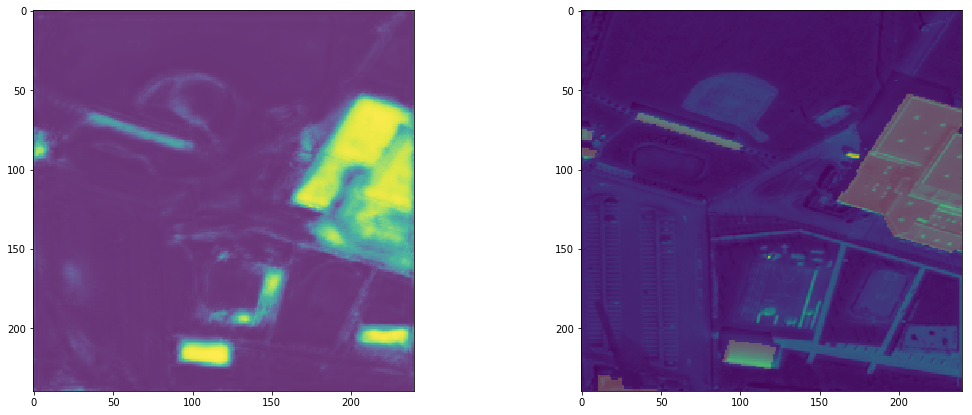

In [25]:
net_plot(net17, data_set16, test_ids[13], average=False)

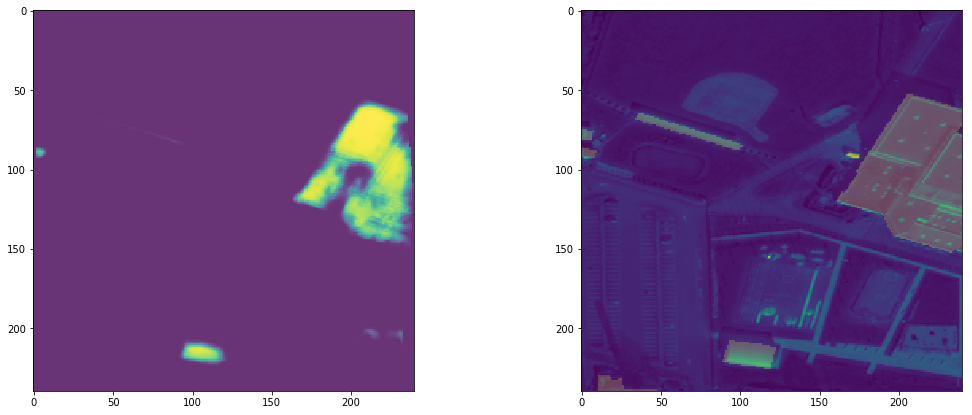

In [28]:
net_plot(net16, data_set16, test_ids[13], average=True)

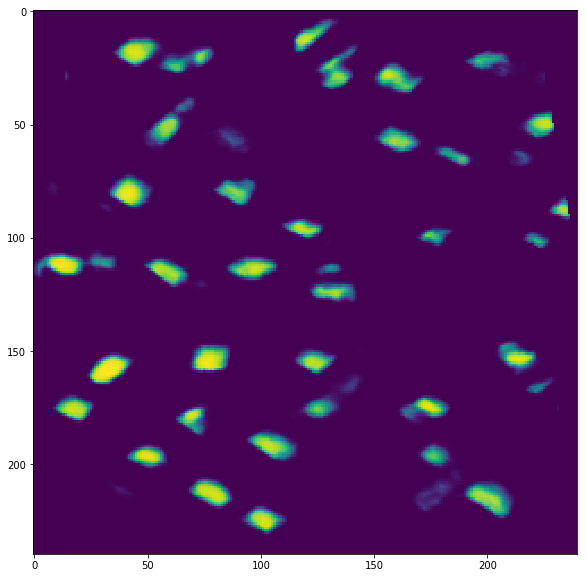

In [109]:
plt.figure(figsize=(10,10))
plt.imshow(Ys[:,:,0])

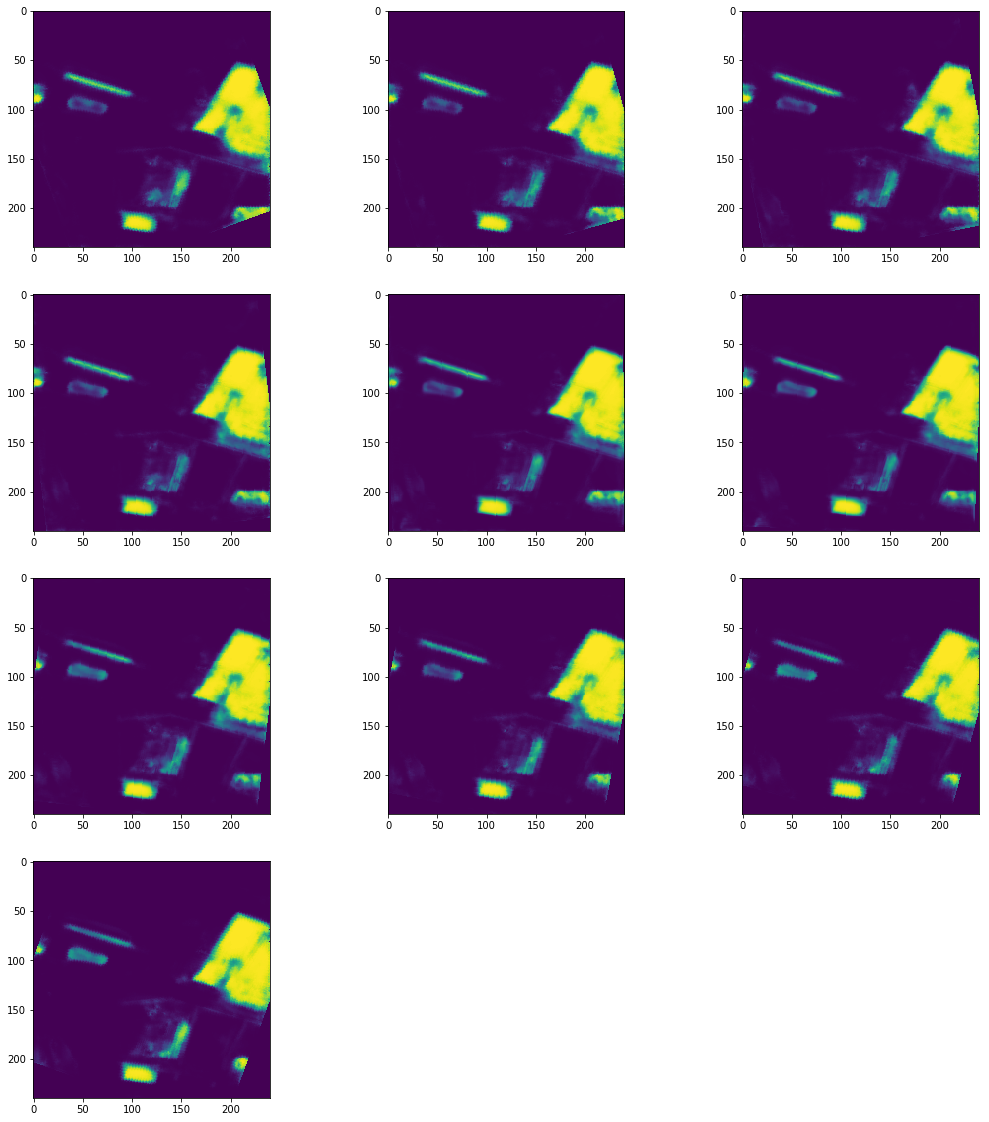

In [95]:
plt.figure(figsize=(18,20))
for i in range(10):
    plt.subplot(4,3, i+1)
    plt.imshow(Ys[i,:,:,0])

In [37]:
batch_generator = lexperiment.BatchGenerator(data_set16, test_ids, shuffle=False)

In [23]:
Ys_arr_pred = np.empty(0)
Ys_arr_true = np.empty(0)
i = 0
for ids, Xs, Ys in batch_generator(10):
    print i
    n = Ys.shape[0] * Ys.shape[1] * Ys.shape[2]
    Ys_arr_pred = np.concatenate([Ys_arr_pred, net16.predict(Xs).reshape(n)])
    Ys_arr_true = np.concatenate([Ys_arr_true, Ys.reshape(n)])
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [28]:
idx = np.argsort(Ys_arr_pred)

In [29]:
ys = Ys_arr_true[idx]

In [33]:
ys.dump("q.np")

In [34]:
ys1 = np.load("q.np")

In [39]:
!ls -l -h q.np

-rw-rw-r-- 1 lebedev lebedev 122M Nov 20 17:42 q.np
